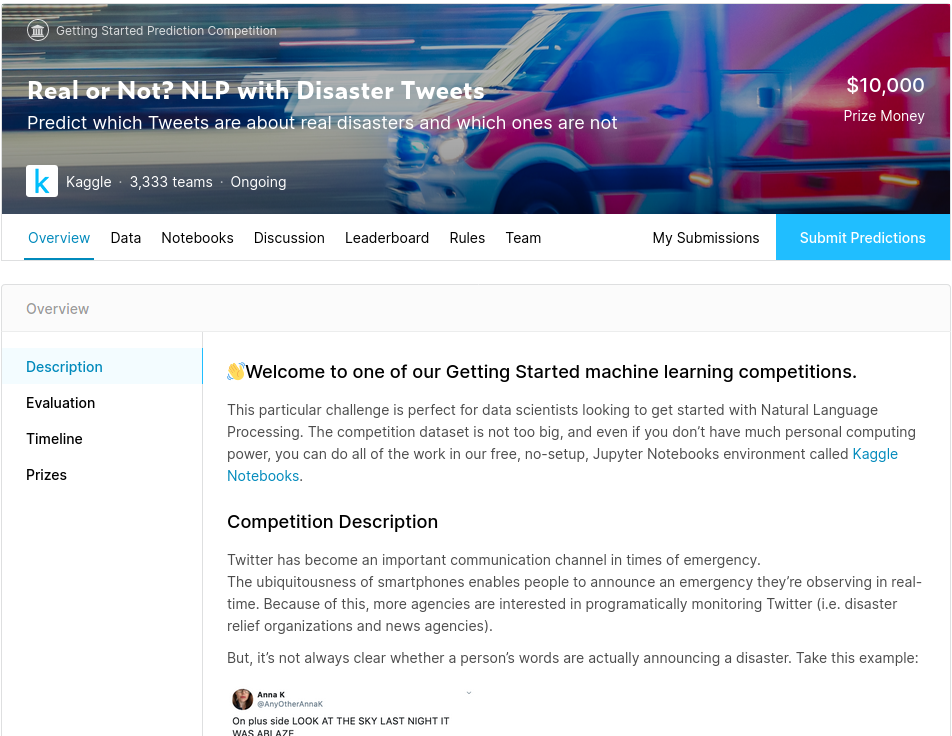

In [22]:
from IPython.display import Image
Image(home/"Image/disaster_tweet_homepage.png")

In [1]:
import csv
import pandas as pd
from pathlib import Path
import matplotlib.cm as cm
from fastai import *
from fastai.text import *
from fastai.callbacks import *
from fastai.metrics import *
import numpy as np
import pandas as pd

from pathlib import Path
from typing import *

import torch
import torch.optim as optim
from sklearn.metrics import classification_report, f1_score , recall_score, precision_score
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
%matplotlib inline
home = Path('/home/wyquek/Documents/Kaggle/NLP with Disaster Tweets')

In [2]:
torch.cuda.is_available()

True

In [3]:
class Config(dict):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        for k, v in kwargs.items():
            setattr(self, k, v)
    
    def set(self, key, val):
        self[key] = val
        setattr(self, key, val)


config = Config(
    testing=False,
    model_name="bert-base-cased",
    max_lr=3e-5,
    epochs=4,
    use_fp16=True,
    bs=32,
    discriminative=False,
    max_seq_len=64,
    #max_seq_len=512,
    num_labels = 2
)

In [4]:
class FastAiTokenizer(BaseTokenizer):
    """Wrapper around BertTokenizer to be compatible with fast.ai"""
    def __init__(self, tokenizer: BertTokenizer, max_seq_len: int=128, **kwargs):
        self._pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len

    def __call__(self, *args, **kwargs):
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length"""
        return ["[CLS]"] + self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + ["[SEP]"]

tok = BertTokenizer.from_pretrained(config.model_name,)
fastai_tokenizer = Tokenizer(tok_func=FastAiTokenizer(tok, max_seq_len=config.max_seq_len), pre_rules=[], post_rules=[])
fastai_vocab = Vocab(list(tok.vocab.keys()))    


In [5]:
home = Path('/home/wyquek/Documents/Kaggle/NLP with Disaster Tweets')

In [6]:
train = pd.read_csv(home/"Data/train.csv")
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
test = pd.read_csv(home/"Data/test.csv")
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [8]:
X_train, X_val = train_test_split(train,test_size = 0.3)

In [9]:
databunch = TextDataBunch.from_df(".",  # 
                    train_df = X_train, 
                    valid_df = X_val,
                    test_df = test,
                  tokenizer=fastai_tokenizer,
                  vocab=fastai_vocab,
                  text_cols="text",
                  label_cols='target',
                  bs=config.bs,
                  collate_fn=partial(pad_collate, pad_first=False, pad_idx=0),)

In [10]:
from transformers import BertPreTrainedModel, BertModel
class BertForSequenceClassification(BertPreTrainedModel):
    def __init__(self, config):
        super(BertForSequenceClassification, self).__init__(config)
        self.num_labels = config.num_labels

        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, self.config.num_labels)
        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None,
                position_ids=None, head_mask=None, inputs_embeds=None, labels=None):

        outputs = self.bert(input_ids,
                            attention_mask=attention_mask,
                            token_type_ids=token_type_ids,
                            position_ids=position_ids,
                            head_mask=head_mask,
                            inputs_embeds=inputs_embeds)

        return self.classifier(self.dropout(outputs[1]))


In [11]:
auto_model = BertForSequenceClassification.from_pretrained(config.model_name, num_labels=config.num_labels)

In [12]:
loss_func = nn.CrossEntropyLoss()
learner = Learner(
    databunch, auto_model,
    metrics=[accuracy],
    loss_func=loss_func)

learner.callbacks.append(ShowGraph(learner))

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-05
Min loss divided by 10: 3.98E-05


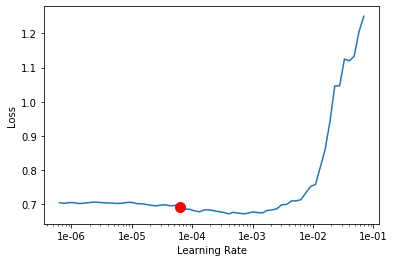

In [13]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,time
0,0.496284,0.471915,0.792032,00:43
1,0.354273,0.454626,0.809107,00:44


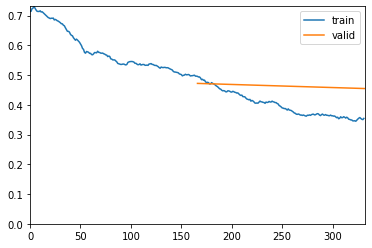

In [14]:
learner.fit_one_cycle(2, slice(1e-4))

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 2.75E-07


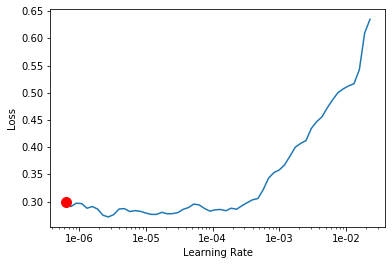

In [15]:
learner.unfreeze()
learner.lr_find()
learner.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,time
0,0.270280,0.451308,0.816112,00:46
1,0.253498,0.455005,0.819177,00:45
2,0.263793,0.457703,0.819177,00:46
3,0.255173,0.457615,0.818301,00:45


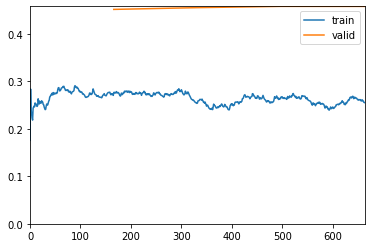

In [16]:
learner.fit_one_cycle(4, slice(6e-7))

In [ ]:
#learner.save('bert_512_stage2')

In [17]:
def get_preds_as_nparray(ds_type) -> np.ndarray:
    """
    the get_preds method does not yield the elements in order by default
    we borrow the code from the RNNLearner to resort the elements into their correct order
    """
    preds = learner.get_preds(ds_type)[0].detach().cpu().numpy()
    sampler = [i for i in databunch.dl(ds_type).sampler]
    reverse_sampler = np.argsort(sampler)
    return np.argmax(preds[reverse_sampler, :], axis = 1)

val_preds = get_preds_as_nparray(DatasetType.Valid)
test_preds = get_preds_as_nparray(DatasetType.Test)

In [18]:
print(classification_report(X_val['target'], val_preds))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84      1276
           1       0.81      0.76      0.79      1008

    accuracy                           0.82      2284
   macro avg       0.82      0.81      0.81      2284
weighted avg       0.82      0.82      0.82      2284



In [19]:
sub = pd.read_csv(home/"Data/sample_submission.csv")
sub.head(3)

,id,target
0,0,0
1,2,0
2,3,0


In [20]:
sub['target'] = test_preds
sub.to_csv(home/'Data/submission.csv', index=False)
sub.head(3)

,id,target
0,0,1
1,2,1
2,3,1


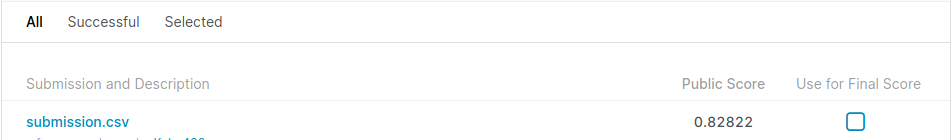

In [21]:
from IPython.display import Image
Image(home/"Image/score.png")